In [1]:
import jax
import matplotlib.pyplot as plt
from models import MeshModel, IcosphereModel
from jax.typing import ArrayLike
from models.mesh_transform import add_rotation, evaluate_rotation, transform
from models.spots import add_spots
from models.binary import Binary, add_orbit, evaluate_orbit
from models.mesh_view import get_mesh_view
from plots import plot_3D
from spectrum import simulate_spectrum, blackbody_intensity
import astropy.units as u
import astropy.constants as const
import jax.numpy as jnp
import numpy as np
from typing import Tuple
from tqdm import tqdm

from jax import config
from jax import jit
config.update("jax_enable_x64", True)

m1 = get_mesh_view(IcosphereModel.construct(1000, u.solRad.to(u.cm), 1.*u.solMass.to(u.kg), 1., jnp.concatenate([jnp.array([3.75]), jnp.ones(19)])), jnp.array([1., 0., 0.]))
m2 = get_mesh_view(transform(IcosphereModel.construct(1000, u.solRad.to(u.cm), 1.*u.solMass.to(u.kg), 1., jnp.concatenate([jnp.array([3.75]), jnp.ones(19)])),
               jnp.array([3*u.solRad.to(u.cm), 0.25*u.solRad.to(u.cm), 0.])), jnp.array([1., 0., 0.]))

In [2]:
b = Binary.from_bodies(m1, m2)
bo = add_orbit(b, .1, 0., 0., 0., 0., 0., 100)

In [3]:
b1, b2 = evaluate_orbit(bo, 1)

Interpolating orbits
Evaluating body orbits


In [4]:
import cProfile
cProfile.run('evaluate_orbit(bo, 1)')

Interpolating orbits
Evaluating body orbits
         9006 function calls (8836 primitive calls) in 10.440 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      353    0.000    0.000    0.000    0.000 <frozen abc>:117(__instancecheck__)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1207(_handle_fromlist)
        4    0.000    0.000    0.000    0.000 <string>:1(<lambda>)
        1    0.000    0.000   10.440   10.440 <string>:1(<module>)
        2    0.000    0.000    0.000    0.000 <string>:2(__init__)
       61    0.000    0.000    0.001    0.000 abstract_arrays.py:56(canonical_concrete_aval)
        2    0.000    0.000    0.000    0.000 abstract_arrays.py:78(_make_concrete_python_scalar)
        1    0.000    0.000    0.002    0.002 api.py:317(infer_params)
        1    0.000    0.000    0.000    0.000 api_util.py:255(_ensure_inbounds)
        1    0.000    0.000    0.000    0.000 api_util.py:2

In [5]:
from jax.stages import Compiled

In [7]:
for i in tqdm(np.linspace(0, .1, 10)):
    b1, b2 = evaluate_orbit(bo, i)
    plt.scatter(b1.center[0], b1.center[1], c='red')
    plt.scatter(b2.center[0], b2.center[1], color='black')

  0%|          | 0/10 [00:00<?, ?it/s]

Interpolating orbits
Evaluating body orbits


In [ ]:
evaluate_orbit_at_times = jax.jit(jax.vmap(evaluate_orbit, in_axes=(None, 0)))

In [ ]:
b1s, b2s = evaluate_orbit_at_times(bo, jnp.linspace(0, 0.1, 100))

In [ ]:
b1s.centers.shape

(100, 1280, 3)

In [ ]:
import matplotlib as mpl
from plots.plot_mesh import _evaluate_to_be_mapped_property
from typing import Optional, Union

def plot_binary_3D(mesh1: MeshModel, mesh2: MeshModel,
                   property: Union[str, int] = 'mus',
                   axes: Optional[Tuple[plt.figure, plt.axes, plt.axes]] = None,
                   cmap: str = 'turbo',
                   property_label: Optional[str] = None,
                   distances_scale: float = 1.0):
    to_be_mapped1, cbar_label = _evaluate_to_be_mapped_property(mesh1, property, property_label)
    to_be_mapped2, _ = _evaluate_to_be_mapped_property(mesh2, property, property_label)
    rescaled_mesh1 = mesh1._replace(center=mesh1.center*distances_scale)
    rescaled_mesh2 = mesh2._replace(center=mesh2.center*distances_scale)

    if axes is None:
        fig = plt.figure(figsize=(10, 12))
        spec = fig.add_gridspec(10, 12)
        plot_ax = fig.add_subplot(spec[:, :11], projection='3d')
        plot_ax.view_init(elev=30, azim=-60)
        cbar_ax = fig.add_subplot(spec[2:8, 11])
    else:
        try:
            fig, plot_ax, cbar_ax = axes
        except ValueError:
            raise ValueError("Pass either no axes or (plt.figure, plt.axes, plt.axes) for the plot axis and colorbar axis")
    separation = 1.1*jnp.max(jnp.abs(rescaled_mesh1.center - rescaled_mesh2.center))
    plot_ax.set_xlim3d(-separation, separation)
    plot_ax.set_ylim3d(-separation, separation)
    plot_ax.set_zlim3d(-separation, separation)
    plot_ax.set_xlabel('$X [R_\odot]$', fontsize=14)
    plot_ax.set_ylabel('$Y [R_\odot]$', fontsize=14)
    plot_ax.set_zlabel('$Z [R_\odot]$', fontsize=14)

    # These are supposed to be equal for both components
    normalized_los_vector1 = mesh1.los_vector/np.linalg.norm(mesh1.los_vector)
    normalized_rotation_axis1 = mesh1.rotation_axis/np.linalg.norm(mesh1.rotation_axis)
    normalized_rotation_axis2 = mesh2.rotation_axis/np.linalg.norm(mesh2.rotation_axis)

    plot_ax.quiver(0., -1.5*separation, 0., *(mesh1.radius*normalized_los_vector1),
                   color='red', linewidth=3., label='LOS vector')
    plot_ax.quiver(*(rescaled_mesh1.center), *(2.0*mesh1.radius*normalized_rotation_axis1),
                   color='black', linewidth=3., label='Rotation axis 1')
    plot_ax.quiver(*(rescaled_mesh2.center), *(2.0*mesh2.radius*normalized_rotation_axis2),
                   color='black', linewidth=3., label='Rotation axis 2')
    plot_ax.legend()

    norm = mpl.colors.Normalize(
        vmin=jnp.concatenate([to_be_mapped1, to_be_mapped2]).min(),
        vmax=jnp.concatenate([to_be_mapped1, to_be_mapped2]).max()
        )

    p = plot_ax.scatter(rescaled_mesh1.centers[:, 0],
                        rescaled_mesh1.centers[:, 1],
                        rescaled_mesh1.centers[:, 2],
                        c=to_be_mapped1, cmap=cmap, norm=norm)
    p = plot_ax.scatter(rescaled_mesh2.centers[:, 0],
                        rescaled_mesh2.centers[:, 1],
                        rescaled_mesh2.centers[:, 2],
                        c=to_be_mapped2, cmap=cmap, norm=norm)
    
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
    cbar.set_label(cbar_label, fontsize=12)

    return fig, plot_ax, cbar_ax


(<Figure size 1000x1200 with 2 Axes>,
 <Axes3D: xlabel='$X [R_\\odot]$', ylabel='$Y [R_\\odot]$', zlabel='$Z [R_\\odot]$'>,
 <Axes: ylabel='$\\mu$'>)

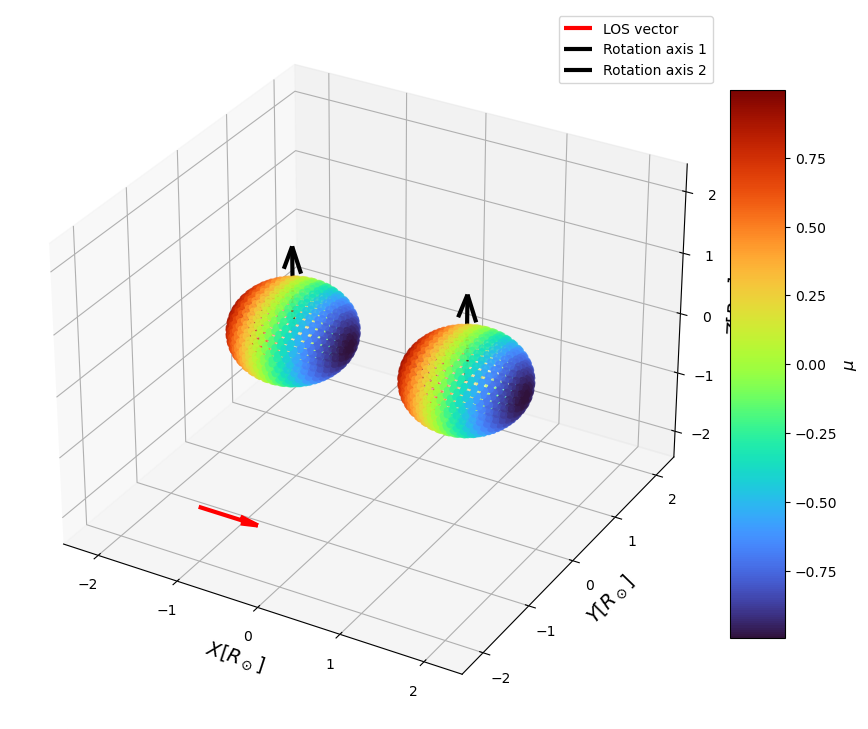

In [ ]:
plot_binary_3D(b1, b2, distances_scale=0.05)

In [ ]:
jnp.argwhere(~jnp.all(jnp.isclose(m1.cast_vertices, 0.), axis=0))

Array([[1],
       [2]], dtype=int64)

In [ ]:
from models import MeshModel, IcosphereModel
from models.mesh_transform import transform
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from geometry import clip, polygon_area
from geometry.utils import wrap
from jax.typing import ArrayLike
import jax

from jax import config
config.update("jax_enable_x64", True)

# Assume the same los_z for the whole triangle
@jax.jit
def visible_area(vertices1: ArrayLike, vertices2: ArrayLike) -> ArrayLike:
    clipped = jnp.nan_to_num(clip(vertices1, vertices2))
    return polygon_area(clipped[:, 0], clipped[:, 1])

total_visible_area = jax.jit(jax.vmap(visible_area, in_axes=(None, 0)))
visibility_areas = jax.jit(jax.vmap(total_visible_area, in_axes=(0, None)))
polygon_areas = jax.jit(jax.vmap(polygon_area, in_axes=(0, 0)))

def casted_areas(mesh1: MeshModel, mesh2: MeshModel) -> ArrayLike:
    nonzero_indexer = jnp.argwhere(~jnp.all(jnp.isclose(mesh1.cast_vertices, 0.), axis=0)).squeeze()
    cast_vertices1 = mesh1.cast_vertices[mesh1.faces.astype(int)][:, :, nonzero_indexer]
    cast_vertices2 = mesh2.cast_vertices[mesh2.faces.astype(int)][:, :, nonzero_indexer]
    occluded = jnp.where(mesh1.los_z<mesh2.los_z, jnp.sum(jnp.where(mesh2.mus>0, visibility_areas(cast_vertices1, cast_vertices2), 0.), axis=1), 0.)
    return jnp.where(mesh1.mus>0, polygon_areas(cast_vertices1[:, :, 0], cast_vertices1[:, :, 1])-occluded, 0)

In [ ]:
c1 = casted_areas(m1, m2)
c2 = casted_areas(m2, m1)

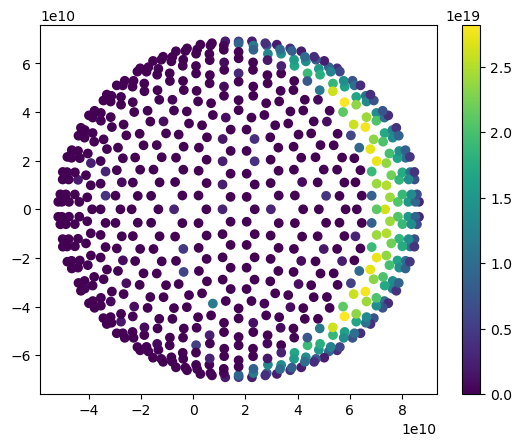

In [ ]:
#plt.scatter(m1.cast_centers[m1.mus>0, 1], m1.cast_centers[m1.mus>0, 2], c=c1[m1.mus>0])
plt.scatter(m2.cast_centers[m2.mus>0, 1], m2.cast_centers[m2.mus>0, 2], c=c2[m2.mus>0])
plt.colorbar()